In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from IPython.display import display, HTML

%matplotlib inline 
# Set default style
sns.set()

In [2]:
%load_ext watermark

In [3]:
%watermark -iv -u -n -t -z

pandas      0.24.2
seaborn     0.9.0
numpy       1.13.3
statsmodels 0.9.0
matplotlib  3.0.3
last updated: Sun Apr 28 2019 13:52:58 Eastern Daylight Time


In [4]:
# File path
outbounds_file = 'Dataset/outbounds14to17.csv'

In [5]:
# Read in data as DataFrame
outbounds = pd.read_csv(outbounds_file, index_col=0, parse_dates=True)
display(outbounds)

,Europe,Caribbean,Asia,South America,Central America,Oceania,Middle East,Africa,Total Overseas,Mexico,Canada,North America,Grand Total
2014-01-31,577691.0,498620.0,376296.0,127749.0,219192.0,51774.0,140179.0,23982.0,2015483.0,2073218.50,450103.0,2523321.50,4538804.50
2014-02-28,497003.0,550203.0,312814.0,137612.0,225540.0,62658.0,119192.0,21066.0,1926088.0,1975580.80,483157.0,2458737.80,4384825.80
2014-03-31,806663.0,705211.0,397296.0,154680.0,283108.0,60097.0,140706.0,27950.0,2575711.0,2396038.50,553030.0,2949068.50,5524779.50
2014-04-30,868367.0,629774.0,381817.0,123068.0,213929.0,41314.0,141744.0,27596.0,2427609.0,2052385.20,662708.0,2715093.20,5142702.20
2014-05-31,1305842.0,624280.0,379197.0,144464.0,209012.0,46359.0,162244.0,36044.0,2907442.0,2123547.90,992697.0,3116244.90,6023686.90
2014-06-30,1614486.0,742860.0,424155.0,208023.0,301095.0,45003.0,180874.0,40542.0,3557038.0,2199477.20,1402535.0,3602012.20,7159050.20
2014-07-31,1413798.0,821650.0,397960.0,167627.0,308557.0,48892.0,148098.0,40732.0,3347314.0,2313740.60,1840827.0,4154567.60,7501881.60
2014-08-31,1185907.0,629224.0,342239.0,143609.0,206176.0,39913.0,145620.0,34231.0,2726919.0,2113128.80,1889787.0,4002915.80,6729834.80
2014-09-30,1241537.0,347244.0,338630.0,112581.0,121158.0,38013.0,133173.0,29205.0,2361541.0,1608221.30,1074367.0,2682588.30,5044129.30
2014-10-31,915090.0,436791.0,397721.0,123729.0,145848.0,46573.0,134341.0,25974.0,2226067.0,1875762.60,860615.0,2736377.60,4962444.60


In [6]:
# Test stationary of grand total
# The function takes in timeseries as parameter
def test_stationary(ts):
    df_test = adfuller(ts, autolag='AIC')
    df_result = pd.Series(df_test[:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in df_test[4].items():
        df_result['Critical Value (%s)'%key] = value
    display(df_result)

In [7]:
# Seasonal decompose on input timeseries and plot the decomposition graphs
# return the decomposition object
def plot_decompose(ts):
    decomp = sm.tsa.seasonal_decompose(ts)
    fig = decomp.plot()
    fig.set_size_inches(5, 8)
    plt.show()
    return decomp

In [8]:
# Calculate normalized root mean square error
def rmse(actual, prediction):
    return np.true_divide(np.sqrt(mean_squared_error(actual, prediction)),np.mean(prediction)) 

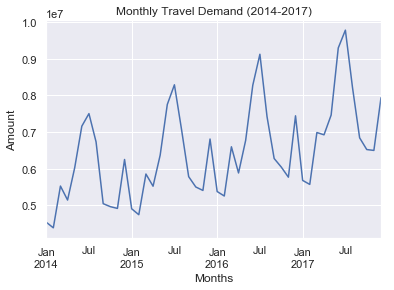

In [9]:
# Plot Overall 
outbounds.loc[:,'Grand Total'].plot()
plt.title("Monthly Travel Demand (2014-2017)")
plt.xlabel("Months")
plt.ylabel("Amount")
plt.show()

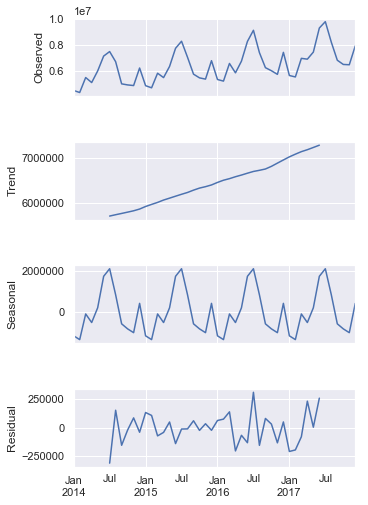

In [10]:
# Seasonal decomposition on Grand Total data
outbounds_decomp = plot_decompose(outbounds['Grand Total'])  

In [11]:
# Set split point
train_size = int(len(outbounds['Grand Total']) * 0.9)
training, testing = outbounds['Grand Total'].iloc[:train_size], outbounds['Grand Total'].iloc[train_size:]
# Inspect training set
display(training.head())
display(training.tail())
# Inspect testing set
display(testing.head())
display(testing.tail())

2014-01-31    4538804.5
2014-02-28    4384825.8
2014-03-31    5524779.5
2014-04-30    5142702.2
2014-05-31    6023686.9
Name: Grand Total, dtype: float64

2017-03-31    6985659.85
2017-04-30    6923482.11
2017-05-31    7461883.86
2017-06-30    9294010.49
2017-07-31    9780424.59
Name: Grand Total, dtype: float64

2017-08-31    8213225.77
2017-09-30    6841226.20
2017-10-31    6521255.50
2017-11-30    6497371.30
2017-12-31    7936415.70
Name: Grand Total, dtype: float64

2017-08-31    8213225.77
2017-09-30    6841226.20
2017-10-31    6521255.50
2017-11-30    6497371.30
2017-12-31    7936415.70
Name: Grand Total, dtype: float64

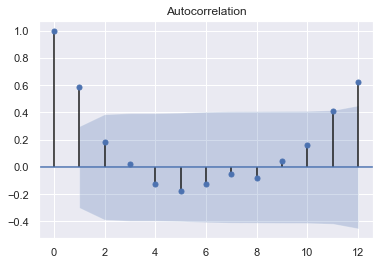

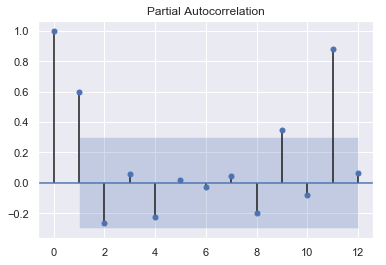

In [12]:
# ACF and PACF of Grand Total
tsaplots.plot_acf(training,lags=12)
tsaplots.plot_pacf(training, lags=12)
plt.show()

In [13]:
# Model data without differencing
orders = [(0,1,0),(0,1,1),(1,1,0),(1,1,1)]
seasonal_orders = [(1,0,0,12),(1,0,1,12),(1,1,0,12)]
trends = ['n','c','t','ct']
min_aic = np.inf
# Loop through each hyperparameters list
for order in orders:
    for seasonal_order in seasonal_orders:
        for trend in trends:
            model = SARIMAX(training, order=order, seasonal_order=seasonal_order, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit()
            print('SARIMA{}x{}: trend={}, AIC={}'.format(order, seasonal_order, trend, results.aic))
            # Check if the current model performs better
            if results.aic < min_aic:
                min_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_trend = trend
# print the best model and its hyperparamters
print('The best model is {}x{} with AIC:{} and trend:{}'.format(best_order, best_seasonal_order, min_aic, best_trend))

C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 0, 0, 12): trend=n, AIC=836.7290103882552
SARIMA(0, 1, 0)x(1, 0, 0, 12): trend=c, AIC=893.6954403721932
SARIMA(0, 1, 0)x(1, 0, 0, 12): trend=t, AIC=893.922145257548


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 0, 0, 12): trend=ct, AIC=895.9169756240146
SARIMA(0, 1, 0)x(1, 0, 1, 12): trend=n, AIC=8860413.122098245


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 0, 1, 12): trend=c, AIC=8550777.813316029
SARIMA(0, 1, 0)x(1, 0, 1, 12): trend=t, AIC=8797208.967536358


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 0, 1, 12): trend=ct, AIC=8778326.702270724
SARIMA(0, 1, 0)x(1, 1, 0, 12): trend=n, AIC=508.51107728195535
SARIMA(0, 1, 0)x(1, 1, 0, 12): trend=c, AIC=510.97627075947


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 1, 0, 12): trend=t, AIC=510.98251848879255
SARIMA(0, 1, 0)x(1, 1, 0, 12): trend=ct, AIC=512.9795535109196
SARIMA(0, 1, 1)x(1, 0, 0, 12): trend=n, AIC=894.9290937034185

C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)



SARIMA(0, 1, 1)x(1, 0, 0, 12): trend=c, AIC=897.1377698159433
SARIMA(0, 1, 1)x(1, 0, 0, 12): trend=t, AIC=897.3810189448021

C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)



SARIMA(0, 1, 1)x(1, 0, 0, 12): trend=ct, AIC=899.390644613082


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(1, 0, 1, 12): trend=n, AIC=7560947.92213905


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(1, 0, 1, 12): trend=c, AIC=7514560.191305124


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(1, 0, 1, 12): trend=t, AIC=7521534.212660361


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(1, 0, 1, 12): trend=ct, AIC=7548869.195262234


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(1, 1, 0, 12): trend=n, AIC=501.58996478399195


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(1, 1, 0, 12): trend=c, AIC=505.7538977776125
SARIMA(0, 1, 1)x(1, 1, 0, 12): trend=t, AIC=512.2710302035877

C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 1)x(1, 1, 0, 12): trend=ct, AIC=512.5996205100755
SARIMA(1, 1, 0)x(1, 0, 0, 12): trend=n, AIC=864.1081501376909


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 0)x(1, 0, 0, 12): trend=c, AIC=866.0550550246363
SARIMA(1, 1, 0)x(1, 0, 0, 12): trend=t, AIC=866.2809711816003


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 0)x(1, 0, 0, 12): trend=ct, AIC=868.2539111939176
SARIMA(1, 1, 0)x(1, 0, 1, 12): trend=n, AIC=8519415.436224572


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 0)x(1, 0, 1, 12): trend=c, AIC=8222673.290590467
SARIMA(1, 1, 0)x(1, 0, 1, 12): trend=t, AIC=8434319.81277604


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 0)x(1, 0, 1, 12): trend=ct, AIC=8369175.253386468
SARIMA(1, 1, 0)x(1, 1, 0, 12): trend=n, AIC=477.8878483747838
SARIMA(1, 1, 0)x(1, 1, 0, 12): trend=c, AIC=479.7429039016776


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 0)x(1, 1, 0, 12): trend=t, AIC=479.83019392591484
SARIMA(1, 1, 0)x(1, 1, 0, 12): trend=ct, AIC=481.7756496335024


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 0, 0, 12): trend=n, AIC=866.7542982238626
SARIMA(1, 1, 1)x(1, 0, 0, 12): trend=c, AIC=868.7872243657711


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 0, 0, 12): trend=t, AIC=868.8964502760118
SARIMA(1, 1, 1)x(1, 0, 0, 12): trend=ct, AIC=870.8967123369018


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 0, 1, 12): trend=n, AIC=7137134.105800359
SARIMA(1, 1, 1)x(1, 0, 1, 12): trend=c, AIC=7120246.197177006


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 0, 1, 12): trend=t, AIC=7075180.244023906
SARIMA(1, 1, 1)x(1, 0, 1, 12): trend=ct, AIC=7087757.416580901


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 1, 0, 12): trend=n, AIC=477.06499210004864


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 1, 0, 12): trend=c, AIC=480.0197721676975
SARIMA(1, 1, 1)x(1, 1, 0, 12): trend=t, AIC=482.3685244676543


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(1, 1, 1)x(1, 1, 0, 12): trend=ct, AIC=483.7134456726338
The best model is (1, 1, 1)x(1, 1, 0, 12) with AIC:477.06499210004864 and trend:n


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


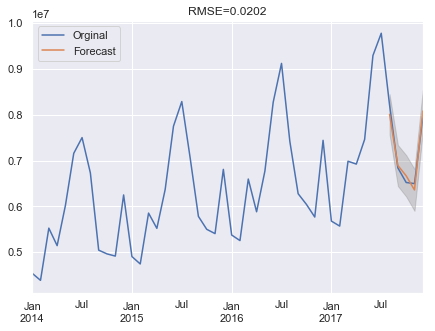

In [14]:
# Create SARIMA model with the best hyperparameters
model_raw = SARIMAX(training, order=best_order, seasonal_order=best_seasonal_order, trend=best_trend, enforce_stationarity=False, enforce_invertibility=False)
# Fit the model
results_raw = model_raw.fit()
# Predict
pred_raw = results_raw.get_forecast(steps=len(testing))
# Get the 95% confidence interval
pred_r_ci = pred_raw.conf_int()
# predicted values
pred_r = pred_raw.predicted_mean
# Plot the predictions and original data
ax = outbounds['Grand Total'].plot(label='Orginal', figsize=(7,5))
pred_r.plot(label='Forecast')
ax.fill_between(pred_r_ci.index, pred_r_ci.iloc[:,0], pred_r_ci.iloc[:,1], color='grey', alpha=0.3)
plt.legend(loc='upper left')
plt.title('RMSE={:.4f}'.format(rmse(testing, pred_r)))
plt.show()

C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


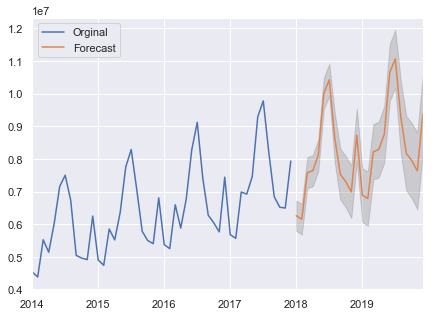

In [15]:
# Forecast 2018 and 2019
# Create date range for prediction
dates1819 = pd.date_range(start='2018-01', end='2019-12-31', freq='M')
# Predict
pred_1819 = results_raw.get_forecast(steps=len(testing)+24)
# Get the 95% confidence interval
pred1819_ci = pred_1819.conf_int().loc['2018-01-31':]
# Get the predictions
predictions1819 = pred_1819.predicted_mean.loc['2018-01-31':]
# Plot the predictions and original data
ax = outbounds['Grand Total'].plot(label='Orginal', figsize=(7,5))
predictions1819.plot(label='Forecast')
ax.fill_between(pred1819_ci.index, pred1819_ci.iloc[:,0], pred1819_ci.iloc[:,1], color='grey', alpha=0.3)
plt.legend(loc='upper left')
plt.show()

2014-01-31    15.328174
2014-02-28    15.293660
2014-03-31    15.524754
2014-04-30    15.453089
2014-05-31    15.611210
Name: Grand Total, dtype: float64

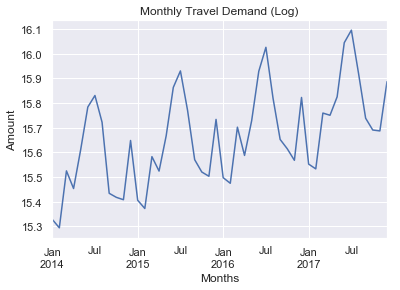

Test Statistic                 -0.430652
p-value                         0.904854
#Lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64

In [16]:
# Check data with logarithm
total_log = outbounds['Grand Total'].apply(lambda x: np.log(x))
display(total_log.head())
total_log.plot()
plt.title("Monthly Travel Demand (Log)")
plt.xlabel('Months')
plt.ylabel('Amount')
plt.show()
# Test stationarity
test_stationary(total_log)

2014-02-28   -0.034514
2014-03-31    0.231093
2014-04-30   -0.071665
2014-05-31    0.158121
2014-06-30    0.172678
Name: Grand Total, dtype: float64

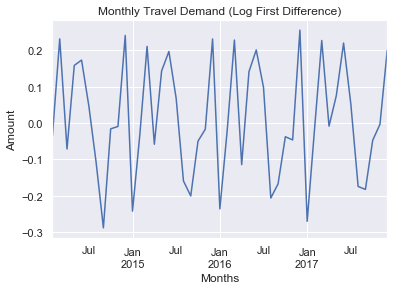

Test Statistic                -30.278580
p-value                         0.000000
#Lags Used                     10.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64

In [17]:
# Log data with first differencing to remove trend
log_first_difference = total_log.diff().dropna()
display(log_first_difference.head())
log_first_difference.plot()
plt.title("Monthly Travel Demand (Log First Difference)")
plt.xlabel('Months')
plt.ylabel('Amount')
plt.show()
# Test stationarity
test_stationary(log_first_difference)

2014-02-28    -153978.7
2014-03-31    1139953.7
2014-04-30    -382077.3
2014-05-31     880984.7
2014-06-30    1135363.3
Name: Grand Total, dtype: float64

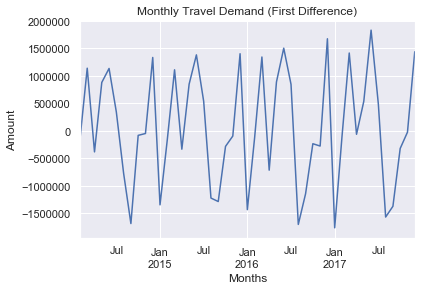

Test Statistic                -27.553492
p-value                         0.000000
#Lags Used                     10.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64

In [18]:
# Data with first differencing to remove trend
first_difference = outbounds['Grand Total'].diff().dropna()
display(first_difference.head())
first_difference.plot()
plt.title("Monthly Travel Demand (First Difference)")
plt.xlabel('Months')
plt.ylabel('Amount')
plt.show()
# Test stationarity
test_stationary(first_difference)

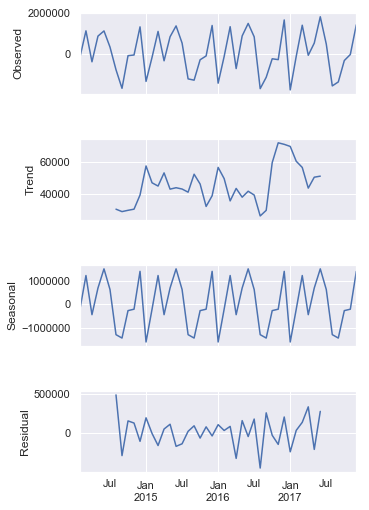

In [19]:
# Check seasonal decomosition
first_difference_decomp = plot_decompose(first_difference)

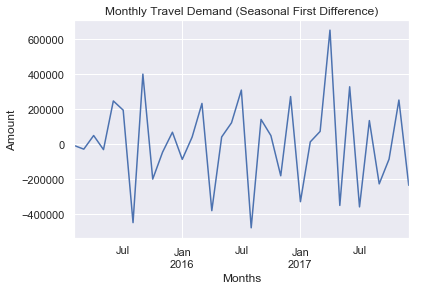

Test Statistic                -1.068986e+01
p-value                        3.750151e-19
#Lags Used                     0.000000e+00
Number of Observations Used    3.400000e+01
Critical Value (1%)           -3.639224e+00
Critical Value (5%)           -2.951230e+00
Critical Value (10%)          -2.614447e+00
dtype: float64

In [20]:
# Seasonal first dirrencing of the data
seasonal_first_difference = first_difference.diff(12).dropna()
seasonal_first_difference.plot()
plt.title("Monthly Travel Demand (Seasonal First Difference)")
plt.xlabel('Months')
plt.ylabel('Amount')
plt.show()
# Test stationarity
test_stationary(seasonal_first_difference)

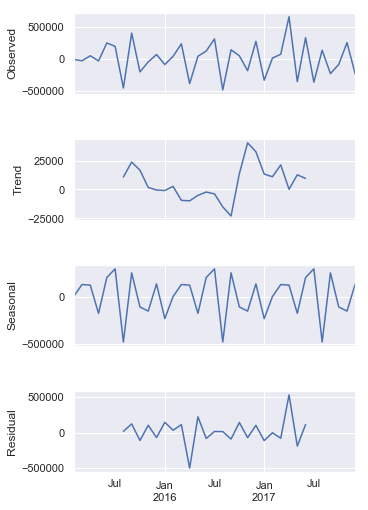

In [21]:
# Check seasonal decomposition
seasonal_first_difference_decomp = plot_decompose(seasonal_first_difference)

In [22]:
# Split into training set and testing set
training_first_diff, testing_first_diff = first_difference[:train_size], first_difference[train_size:]
# Inspect training set
display(training_first_diff.head())
display(training_first_diff.tail())
# Inspect testing set
display(testing_first_diff.head())
display(testing_first_diff.tail())

2014-02-28    -153978.7
2014-03-31    1139953.7
2014-04-30    -382077.3
2014-05-31     880984.7
2014-06-30    1135363.3
Name: Grand Total, dtype: float64

2017-04-30     -62177.74
2017-05-31     538401.75
2017-06-30    1832126.63
2017-07-31     486414.10
2017-08-31   -1567198.82
Name: Grand Total, dtype: float64

2017-09-30   -1371999.57
2017-10-31    -319970.70
2017-11-30     -23884.20
2017-12-31    1439044.40
Name: Grand Total, dtype: float64

2017-09-30   -1371999.57
2017-10-31    -319970.70
2017-11-30     -23884.20
2017-12-31    1439044.40
Name: Grand Total, dtype: float64

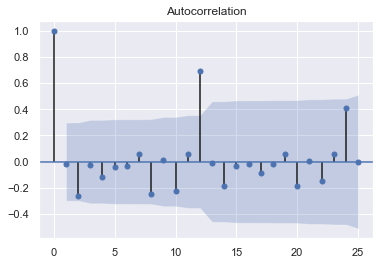

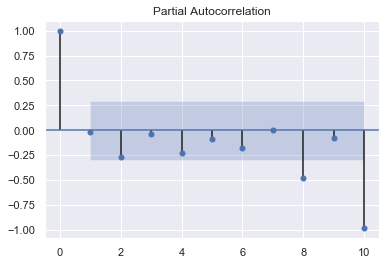

In [23]:
# ACF and PACF of First Difference
tsaplots.plot_acf(training_first_diff, lags=25)
tsaplots.plot_pacf(training_first_diff, lags=10)
plt.show()

In [24]:
# Model data after stationarized
# Find the best perform model
orders = [(0,0,0),(0,1,0)]
seasonal_orders = [(1,0,0,12),(1,0,1,12),(1,1,0,12),(0,1,0,12)]
trends = ['n','c','t','ct']
min_aic = np.inf
# Loop through each list
for order in orders:
    for seasonal_order in seasonal_orders:
        for trend in trends:
            model = SARIMAX(training_first_diff, order=order, seasonal_order=seasonal_order, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit()
            print('SARIMA{}x{}: trend={}, AIC={}'.format(order, seasonal_order, trend, results.aic))
            # Compare if this model performs better
            if results.aic < min_aic:
                min_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_trend = trend
# Print the best model and its hyperparamters
print('The best model is {}x{} with AIC:{} and trend:{}'.format(best_order, best_seasonal_order, min_aic, best_trend))

C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 0, 0)x(1, 0, 0, 12): trend=n, AIC=864.2433389126962
SARIMA(0, 0, 0)x(1, 0, 0, 12): trend=c, AIC=924.0982667079206
SARIMA(0, 0, 0)x(1, 0, 0, 12): trend=t, AIC=924.1316075533227
SARIMA(0, 0, 0)x(1, 0, 0, 12): trend=ct, AIC=926.093208694838


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 0, 0)x(1, 0, 1, 12): trend=n, AIC=10670823.951555578


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 0, 0)x(1, 0, 1, 12): trend=c, AIC=10662497.379698781
SARIMA(0, 0, 0)x(1, 0, 1, 12): trend=t, AIC=10485328.147170393
SARIMA(0, 0, 0)x(1, 0, 1, 12): trend=ct, AIC=10659481.395847986


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 0, 0)x(1, 1, 0, 12): trend=n, AIC=535.7894952742772
SARIMA(0, 0, 0)x(1, 1, 0, 12): trend=c, AIC=538.1586640217753
SARIMA(0, 0, 0)x(1, 1, 0, 12): trend=t, AIC=538.1558344081287

C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)



SARIMA(0, 0, 0)x(1, 1, 0, 12): trend=ct, AIC=540.1500347506117
SARIMA(0, 0, 0)x(0, 1, 0, 12): trend=n, AIC=838.6555606851376


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 0, 0)x(0, 1, 0, 12): trend=c, AIC=838.3825821537064
SARIMA(0, 0, 0)x(0, 1, 0, 12): trend=t, AIC=838.4021749178805
SARIMA(0, 0, 0)x(0, 1, 0, 12): trend=ct, AIC=840.389032341178


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 0, 0, 12): trend=n, AIC=872.2643552694612
SARIMA(0, 1, 0)x(1, 0, 0, 12): trend=c, AIC=916.5793711962251
SARIMA(0, 1, 0)x(1, 0, 0, 12): trend=t, AIC=916.6217382750875


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 0, 0, 12): trend=ct, AIC=918.6253775226307


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 0, 1, 12): trend=n, AIC=18360267.605872724


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 0, 1, 12): trend=c, AIC=18207630.987126853


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 0, 1, 12): trend=t, AIC=18275965.76109612


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 0, 1, 12): trend=ct, AIC=18727294.99982332
SARIMA(0, 1, 0)x(1, 1, 0, 12): trend=n, AIC=529.0718777650723


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


SARIMA(0, 1, 0)x(1, 1, 0, 12): trend=c, AIC=531.5310821898443
SARIMA(0, 1, 0)x(1, 1, 0, 12): trend=t, AIC=531.5333785378349
SARIMA(0, 1, 0)x(1, 1, 0, 12): trend=ct, AIC=533.5373702986234
SARIMA(0, 1, 0)x(0, 1, 0, 12): trend=n, AIC=845.1839490457927

C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)



SARIMA(0, 1, 0)x(0, 1, 0, 12): trend=c, AIC=844.6209398293341
SARIMA(0, 1, 0)x(0, 1, 0, 12): trend=t, AIC=844.6221805825131
SARIMA(0, 1, 0)x(0, 1, 0, 12): trend=ct, AIC=846.625906337257
The best model is (0, 1, 0)x(1, 1, 0, 12) with AIC:529.0718777650723 and trend:n


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


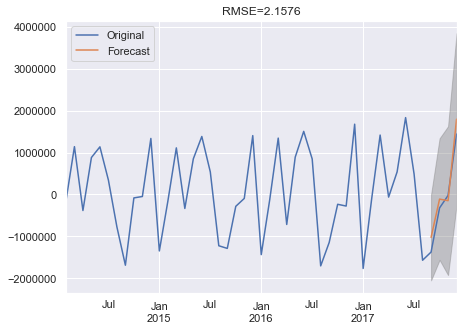

In [25]:
# Create SARIMA model with best hyperparameters
model = SARIMAX(training_first_diff, order=best_order, seasonal_order=best_seasonal_order, trend=best_trend, enforce_stationarity=False, enforce_invertibility=False)
# Fit the model
model_fit = model.fit()
# Predict
pred = model_fit.get_forecast(steps=len(testing_first_diff))
# Get the 95% confidence interval
pred_ci = pred.conf_int()
# Get the predicted values
predictions = pred.predicted_mean
# Plot actual values and predicted values to compare
ax = first_difference.plot(label='Original', figsize=(7,5))
predictions.plot(label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='grey', alpha=0.4)
plt.legend(loc='upper left')
plt.title('RMSE={:.4f}'.format(rmse(testing_first_diff, predictions)))
plt.show()

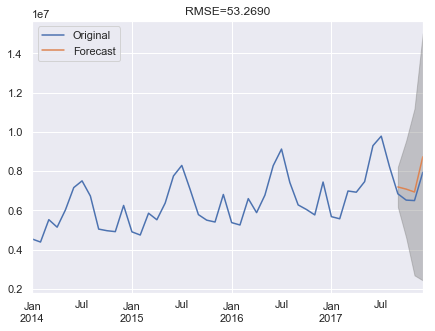

In [26]:
# Invert back to scale to compare
# Get the last day in training set
last_date = training_first_diff.index[-1]
# Get the confidence interval
pred_ci_inverted = pred.conf_int().cumsum().add(outbounds['Grand Total'].loc[last_date])
# Get the predicted values
predictions_inverted = pred.predicted_mean.cumsum().add(outbounds['Grand Total'].loc[last_date])
# Plot original data and predicted values
ax = outbounds['Grand Total'].plot(label='Original', figsize=(7,5))
predictions_inverted.plot(label='Forecast')
ax.fill_between(pred_ci_inverted.index, pred_ci_inverted.iloc[:,0], pred_ci_inverted.iloc[:,1], color='grey', alpha=0.4)
plt.legend(loc='upper left')
plt.title('RMSE={:.4f}'.format(rmse(outbounds['Grand Total'].loc[testing_first_diff.index], predictions)))
plt.show()

C:\Users\supengwen\Miniconda2\envs\cp2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


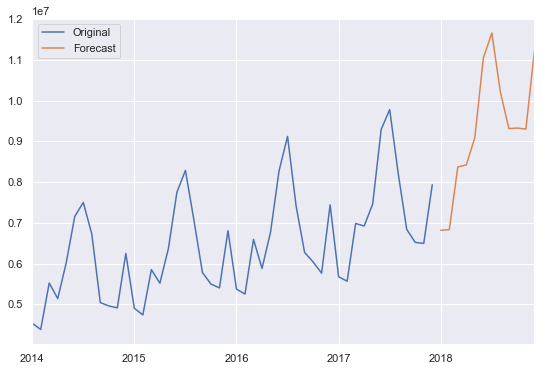

In [27]:
# Forecast 2018
# Predict
pred_2018 = model_fit.get_forecast(steps=len(testing_first_diff)+12)
# Get the 95% confidence interval
pred18_ci = pred_2018.conf_int().cumsum().add(outbounds['Grand Total'].iloc[-1])
# Get the predicted values
pred18 = pred_2018.predicted_mean.cumsum().add(outbounds['Grand Total'].iloc[-1])
# Plot the original data and predicted values
ax = outbounds['Grand Total'].plot(label='Original', figsize=(9,6))
pred18.loc['2018-01-31':].plot(label='Forecast')
plt.legend(loc='upper left')
plt.show()